# ReadMe
The purpose of this project is to identify if it is possible to determine 10 different animals distinctly using my own CNN model. 

I am using a dataset from kaggle.com that contains 10 folders. These folders include images scraped from google based on the animal choosen. Some folders have as few as 1400 images, where others have upto 4500 images.


https://www.kaggle.com/datasets/alessiocorrado99/animals10

In [ ]:
pip install scikeras[tensorflow]

In [ ]:
import pandas as pd       # by Isaac Rodriguez
import numpy as np
from keras import layers, models
from google.colab import files
import zipfile
from PIL import Image
import glob
from keras.layers import Dropout, BatchNormalization
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from keras import layers, models
from keras import callbacks

In [ ]:
uploaded = files.upload() # uploads compressed data

In [ ]:
for fn in uploaded.keys():
  name = fn
zfile = zipfile.ZipFile(name, 'r')   # unzip the directory 
zfile.extractall()

In [ ]:
def Horizontal_flip(image):       # flips images to create more variations
  return image.transpose(Image.FLIP_LEFT_RIGHT)

# Images to Dataset

In [ ]:
## This block of code takes the folders of pictures in the unzipped data
## and extracts one by one by putting them into a list and saving what kind 
## of animal the picture is. Once the list is finished, they are converted to arrays

images = [] 
# this is the alphabetical order the folders are saved in the zip file.
#animals = ['butterfly','cat','chicken','cow','dog','elephant','horse','sheep','spider','squirrel']
animals = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
target = [] 
spider_dog_chicken = ['cane', 'gallina', 'ragno']
for folders in animals:   # goes through folders that are included in animals
  for f in glob.iglob('/content/raw-img/'+ str(folders) +'/*.jpeg'): # extracts image
    im = Image.open(f)
    im = im.resize((150,150))

    images.append(np.asarray(im))    # adds image to images list
    target.append(folders)    # adds whats kind of animal image is to another list
    
    if folders not in spider_dog_chicken:   # These classes already have too many images
      images.append(np.asarray(Horizontal_flip(im)))   # we do not flip these three classes
      target.append(folders)  
        
X = np.array(images)            #  Array of images    
y = np.array(target)          #  Array of animal names in line with X

In [ ]:
# Take the data and splits it up into training, testing sets and validation set
# in this case I decided to shuffle the data to avoid the model seeing too much 
# of the same animal at once.
X = X[0:-1] #
y = y[0:-1] # needed to remove very last element in order to have an even lenght
Y = pd.get_dummies(y)     # encodes classes
X_train, X_remaining, y_train, y_remaining = train_test_split(X, Y, shuffle=True, train_size = 0.8)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.10)

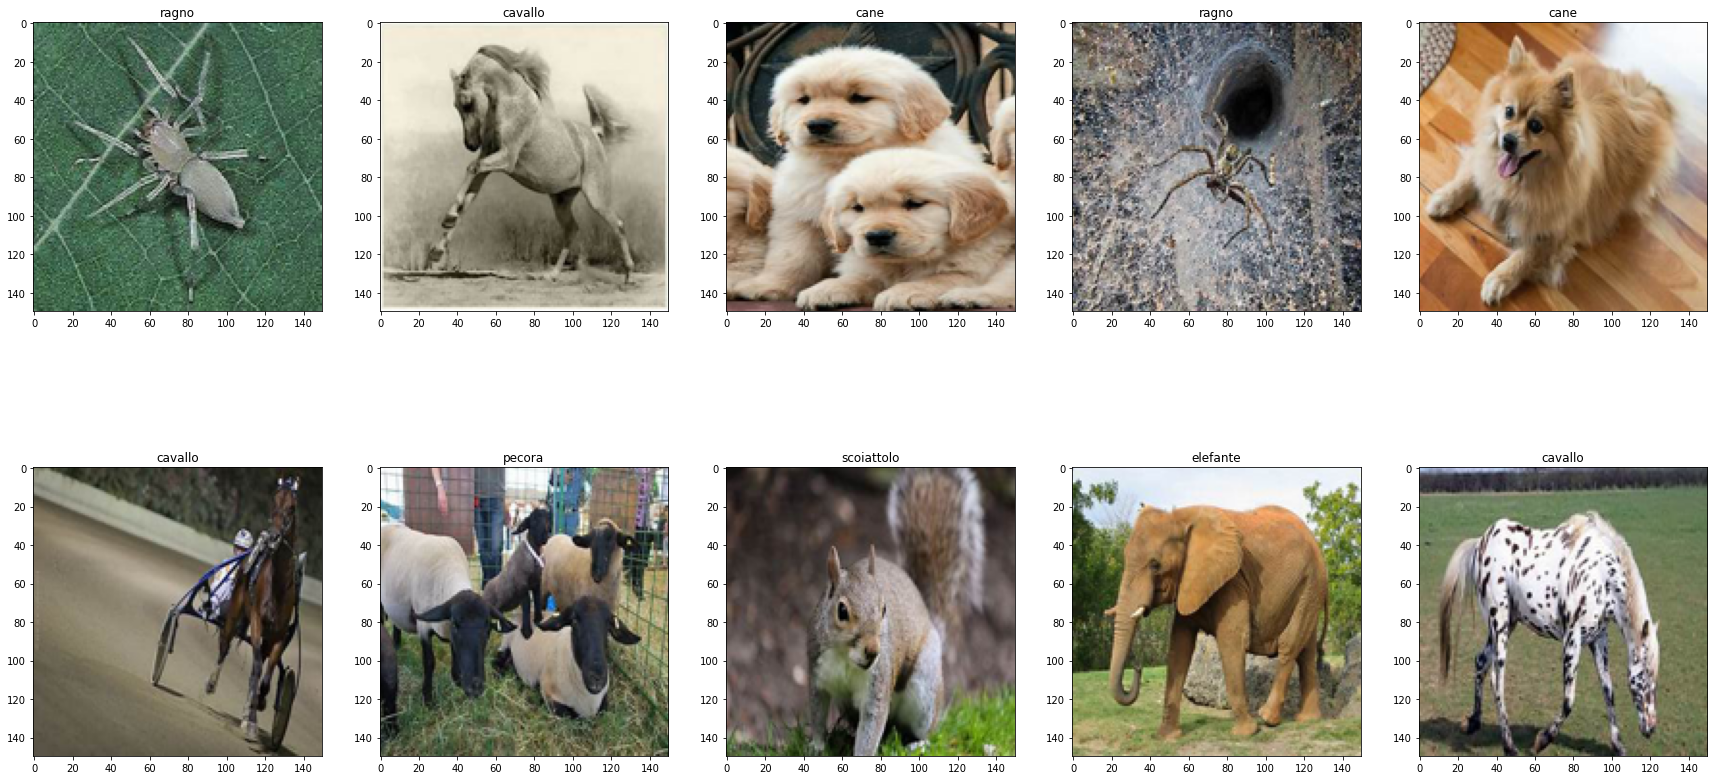

In [ ]:
# displays first 10 pictures in X_train

f = plt.figure(figsize=(30,15))   # makes figure bigger
for i in range(10):                 # 
  ax = f.add_subplot(2, 5, i+1)     # displays 10 sub figures
  ax.title.set_text(str(y[y_train.index[i]])) #
  ax.imshow(X_train[i])             #

In [ ]:
#
# Simple Convolutional Neural Network
# This is a simple network taken from "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurelien Geron"
# The basic structure is taken from this book. I have modified it through trial and error until i achived good results
#

def cnn_model():  
  model_layers = [
    layers.Conv2D(32,(3,3), padding='same', input_shape=[150,150,3]),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2,padding='same'),
    layers.Dropout(0.3),

    layers.Conv2D(64,(3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2,padding='same'),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10,activation='softmax')
  ]
  model_original = models.Sequential(model_layers)

  model_original.compile(loss='categorical_crossentropy',optimizer='rmsprop', metrics=['categorical_accuracy']) 
  return model_original


In [ ]:
classifier_cnn = KerasClassifier(model=cnn_model)

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 3, restore_best_weights = True)
hist = classifier_cnn.fit(X_train, y_train, batch_size=64, epochs = 4,validation_data =(X_val, y_val), callbacks =[earlystopping])

Epoch 1/4
450/450 [==============================] - 1528s 3s/step - loss: 1.9201 - categorical_accuracy: 0.3488 - val_loss: 1.6457 - val_categorical_accuracy: 0.4380
Epoch 2/4
450/450 [==============================] - 1464s 3s/step - loss: 1.4501 - categorical_accuracy: 0.4933 - val_loss: 1.5866 - val_categorical_accuracy: 0.4540
Epoch 3/4
450/450 [==============================] - 1465s 3s/step - loss: 1.2625 - categorical_accuracy: 0.5616 - val_loss: 1.5816 - val_categorical_accuracy: 0.4507
Epoch 4/4
450/450 [==============================] - 1444s 3s/step - loss: 1.1116 - categorical_accuracy: 0.6183 - val_loss: 1.0970 - val_categorical_accuracy: 0.6278


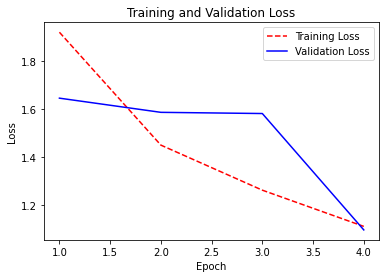

In [ ]:
# In this section I plotted the losses and accuracies to better understand overfitting.


# Get training and test loss histories
training_loss = hist.history_['loss']
test_loss = hist.history_['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

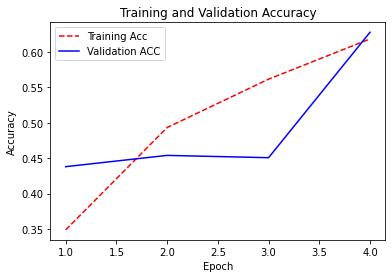

In [ ]:
# Get accuracies and plot
training_acc = hist.history_['categorical_accuracy']
test_acc = hist.history_['val_categorical_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Acc', 'Validation ACC'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

In [ ]:
#animals = ['dog', 'horse', 'elephant', 'butterfly','chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
pred = classifier_cnn.predict(X_test)
print(classification_report(y_test, pred, target_names=animals))

23/23 [==============================] - 9s 370ms/step
              precision    recall  f1-score   support

        cane       0.45      0.73      0.56        94
     cavallo       0.80      0.70      0.75       120
    elefante       0.66      0.41      0.51        46
    farfalla       0.93      0.63      0.75        60
     gallina       0.66      0.62      0.64        77
       gatto       0.45      0.32      0.38        47
       mucca       0.70      0.41      0.52        78
      pecora       0.46      0.77      0.58        48
       ragno       0.62      0.69      0.65        74
  scoiattolo       0.65      0.67      0.66        76

   micro avg       0.62      0.62      0.62       720
   macro avg       0.64      0.60      0.60       720
weighted avg       0.65      0.62      0.62       720
 samples avg       0.62      0.62      0.62       720



In [ ]:
# transform encoded names to english
pred = pd.DataFrame(data = pred, columns = animals) 
pred = pred.idxmax(axis=1)
y_test_names = y_test.idxmax(axis=1)

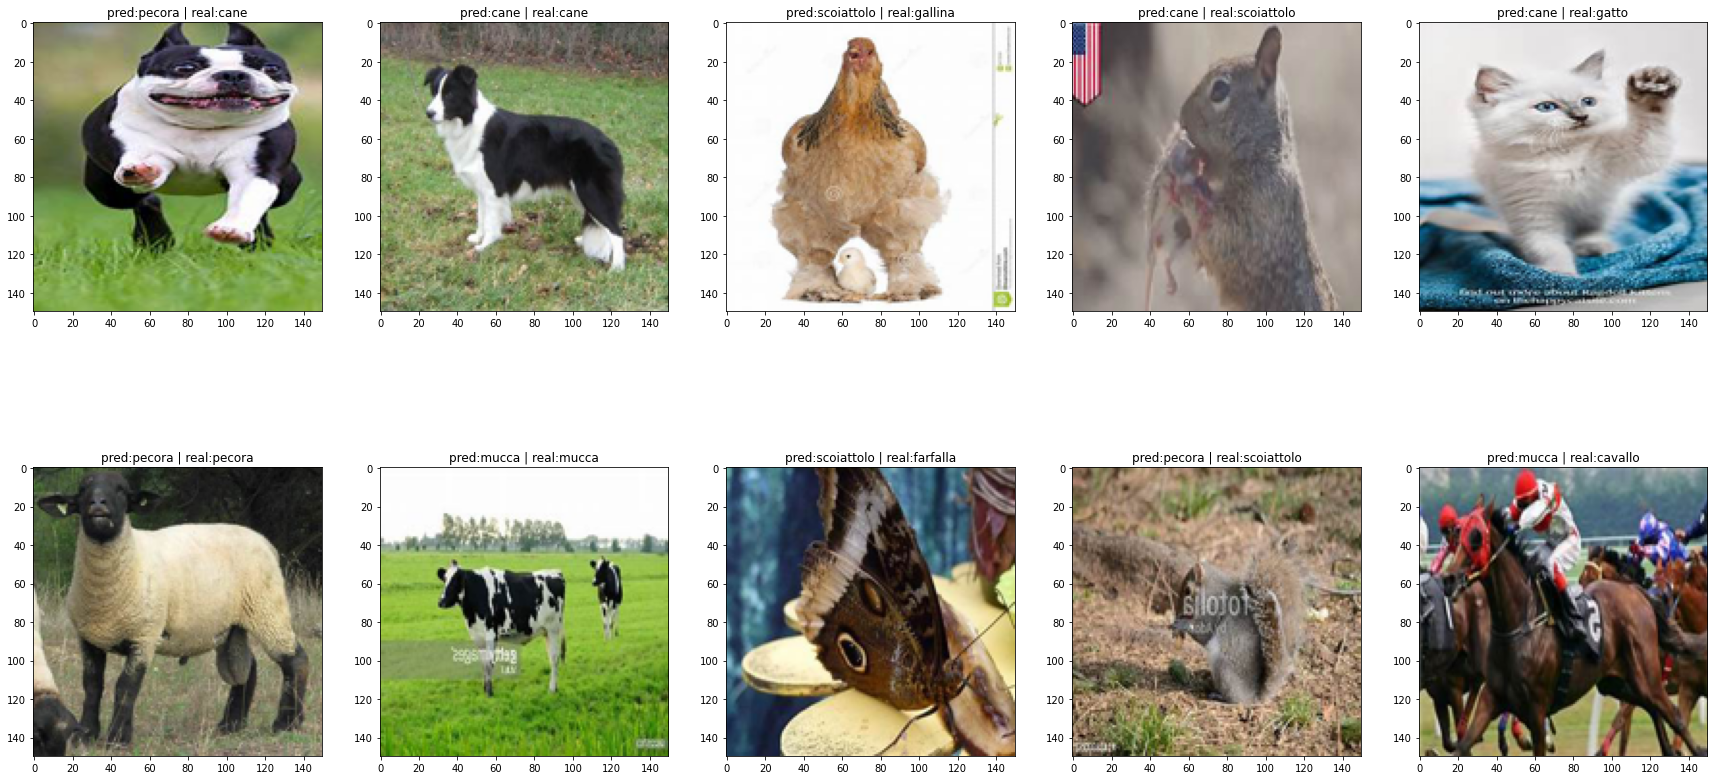

In [ ]:
# displays first 10 predictions
f = plt.figure(figsize=(30,15))   # makes figure bigger
for i in range(10):                                                              # 
  ax = f.add_subplot(2, 5, i+1)                                                  # displays 10 sub figures
  ax.title.set_text('pred:'+str(pred[i])+' | real:'+str(y_test_names.iloc[i]))   #
  ax.imshow(X_test[i])                                                           #

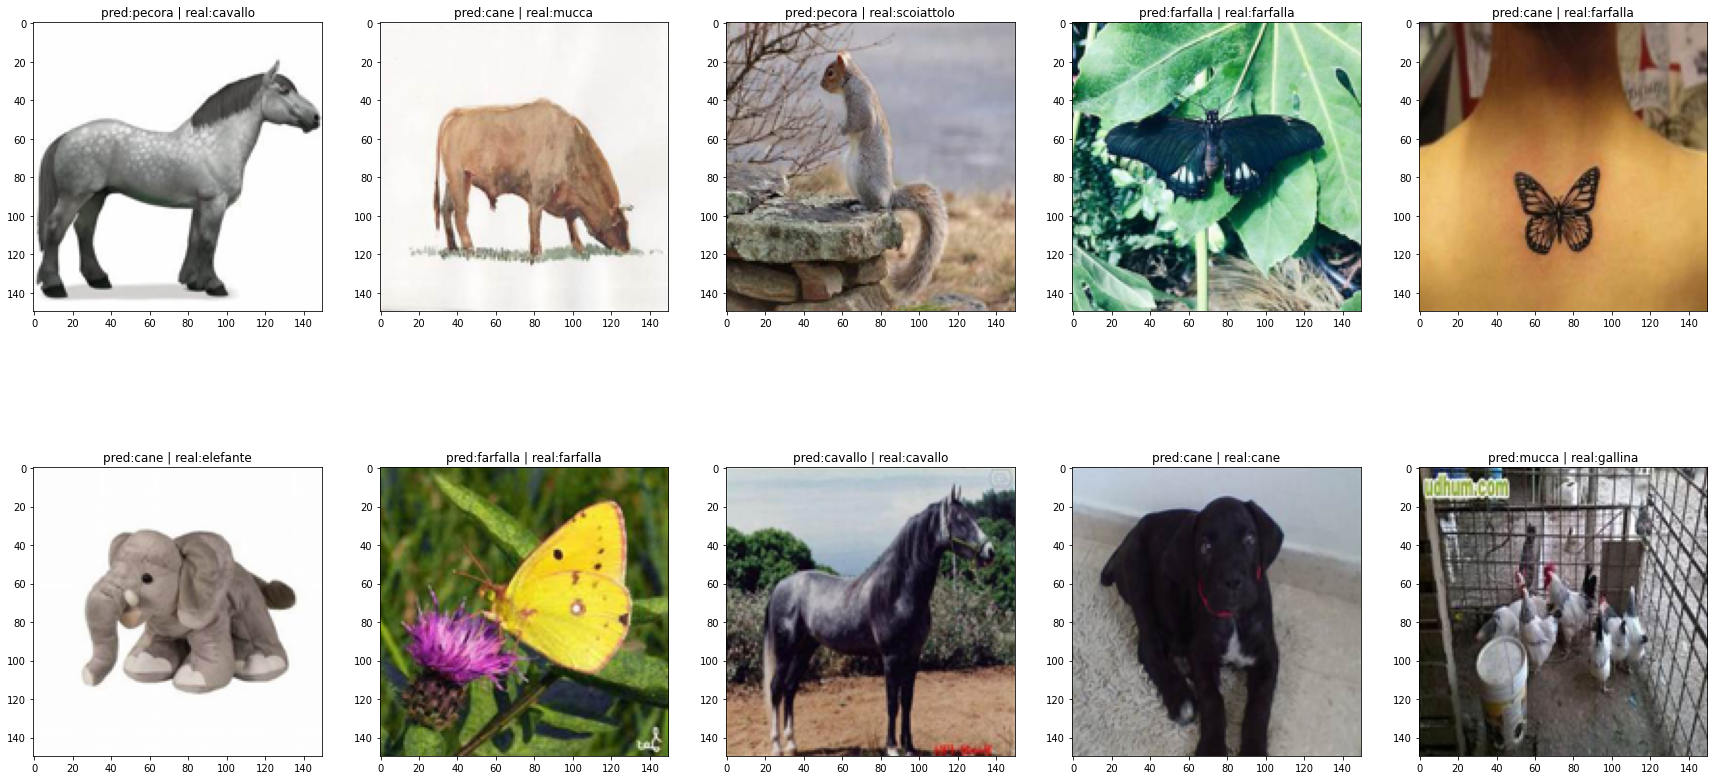

In [ ]:
# displays first 10-20 predictions
f = plt.figure(figsize=(30,15))   # makes figure bigger
for i in range(10):                                                                    # 
  ax = f.add_subplot(2, 5, i+1)                                                        # displays 10 sub figures
  ax.title.set_text('pred:'+str(pred[i+10])+' | real:'+str(y_test_names.iloc[i+10]))   #
  ax.imshow(X_test[i+10])                                                              #

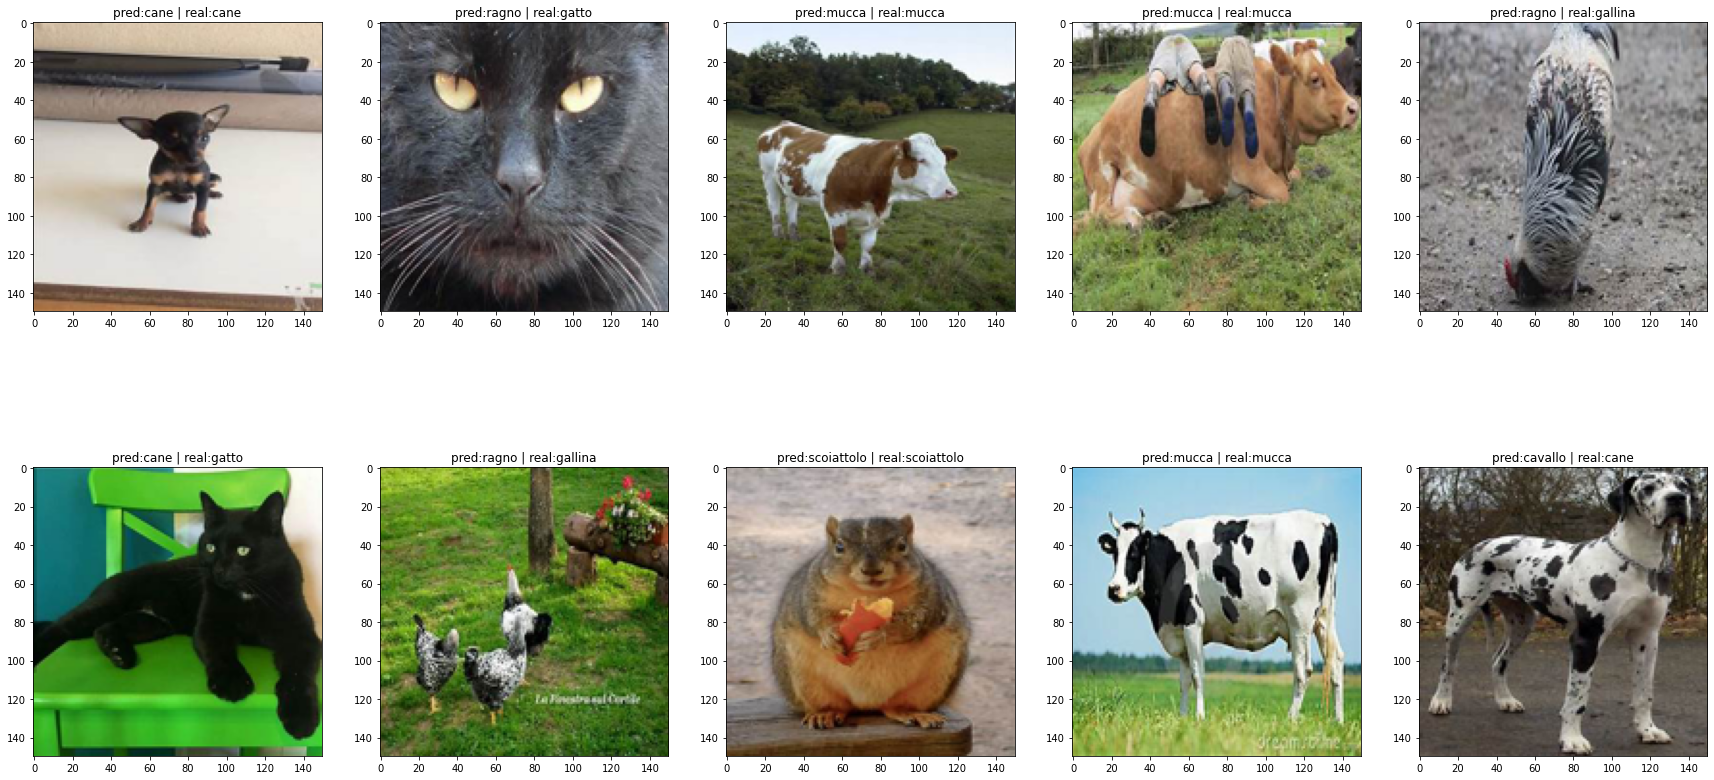

In [ ]:
# displays first 10-20 predictions
f = plt.figure(figsize=(30,15))   # makes figure bigger
for i in range(10):                 # 
  ax = f.add_subplot(2, 5, i+1)     # displays 10 sub figures
  ax.title.set_text('pred:'+str(pred[i+20])+' | real:'+str(y_test_names.iloc[i+20]))   #
  ax.imshow(X_test[i+20]) 